In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'
import ruptures as rpt

# Aggregating Features

The following cells work to aggregate a lot of sensor data and them add additional data for each user's slope for that data throughout the term. The files we used were taken from the following github: 

In [2]:
def to_doy(stri): 
    """
    given an input string, returns the datetime of that string in Y-m-d format. 
    """
    date = dt.strptime(stri, '%Y-%m-%d')
    return date

In [3]:
from sklearn.linear_model import LinearRegression
def linear_coef(X, Y): 
    """
    given pandas series X and Y, returns the overall slope of those series over the course of the term. this is used to 
    find behavioral slopes for time periods, where X is time and y is a behavior. 
    """
    x_2 = X.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_2, Y)
    # commented section plots slope
    #data = pd.DataFrame({'x': X, 'y': Y})
    #sns.regplot(x='x', y='y', data = data, ci = None)
    return model.coef_

In [4]:
#linear_coef(bedtime[bedtime['uid'] == 'u00'].day, bedtime[bedtime['uid'] == 'u00'].night_duration)

In [5]:
def epoch(times_tuple):
    """
    input: tuple containing start and end times (in hours on 24 hour scale)
    output: the epoch that corresponds to the timestamps
    note: we chose to only return timestamps that had both start and end time within a single epoch. An alternative would
    be splitting conversations that span multiple epochs into two conversations, one in each epoch, but we decided not to 
    because that would double count conversations for each user.  
    """
    start = times_tuple[0]
    end = times_tuple[1]
    
    # Day epoch: hours 10 am -6 pm
    if (start and end) >= 10 and (start and end) <18 :
        return 'Day'
    # Night epoch: 12 am - 10 am
    elif (start and end)<10:
        return 'Night'
    # evening epoch: 6 pm - 12 am
    elif (start and end) >= 18:
        return 'Evening'

The following cells aggregate data from various sensors in a format including the day of the year and the column of interest renamed to a more descriptive name

In [6]:
def process_sensors(): 
    # grades data
    grades = pd.read_csv('tables/grades/grades.csv')

    # sleep duration data
    bedtime = pd.read_csv("tables/bedtime/bedtime.csv")
    bedtime['day'] = bedtime['date'].apply(to_doy)
    bedtime['day'] = bedtime['day'].dt.dayofyear

    # study events include all studying that occured for over 20 minutes, calculated by finding the times when 
    # a student was in a study location (ie libraries) from the wifi location data 
    study_events = pd.read_csv('tables/study_events/study_events.csv')
    study_events['day'] = study_events['date'].apply(lambda x: dt.strptime(x, '%m/%d/%Y'))
    study_events['day'] = study_events['day'].dt.dayofyear
    study_events = study_events.rename(columns = {'event_delta': 'study duration'})

    # study quietness cross references audio with study events
    study_quietness = pd.read_csv('tables/study_quiteness/study_quiteness.csv')
    study_quietness['day'] = pd.to_datetime(study_quietness['timestamp'], unit = 's').dt.dayofyear
    study_quietness = study_quietness.rename(columns = {' audio inference': 'noise while studying'})

    # study stillness cross references activity with study events
    study_stillness = pd.read_csv('tables/study_stillness/study_stillness.csv')
    study_stillness['day'] = pd.to_datetime(study_stillness['timestamp'], unit = 's').dt.dayofyear
    study_stillness = study_stillness.rename(columns = {' activity inference': 'activity while studying'})

    # darkness data 
    darkness = pd.read_csv('tables/dark/dark.csv')
    darkness = darkness.rename(columns = {'duration': 'darkness duration'})
    darkness['day'] = darkness['date'].apply(lambda x: dt.strptime(x, '%m/%d/%Y')).dt.dayofyear
    
    return bedtime, study_events, study_quietness, study_stillness, darkness

In [7]:
bedtime, study_events, study_quietness, study_stillness, darkness = process_sensors()

In [8]:
def load_partying():
    """
    I found the partying inference data in another notebook, called analyze audio, partying, and saved it to a csv. 
    Here I load the csv and make a day column for the partying feature. 
    """
    partying = pd.read_csv('dataset/sensing/partying/partying.csv')
    partying['day'] = pd.to_datetime(partying['start time'], unit='s').dt.dayofyear
    partying['day of week'] = pd.to_datetime(partying['start time'], unit = 's').dt.dayofweek
    partying = partying.rename(columns = {'duration' : 'party duration'})
    return partying

In [9]:
partying = load_partying()
partying

,start time,end time,proportion loud labels,uid,party duration,day,day of week
0,1.364923e+09,1.364927e+09,0.938559,u45,4610.0,92,1
1,1.365018e+09,1.365021e+09,0.903483,u45,2296.0,93,2
2,1.365021e+09,1.365023e+09,0.913175,u45,1902.0,93,2
3,1.365189e+09,1.365193e+09,0.965458,u45,4070.0,95,4
4,1.365257e+09,1.365259e+09,0.713089,u45,1833.0,96,5
...,...,...,...,...,...,...,...
4048,1.367823e+09,1.367829e+09,0.731011,u31,5746.0,126,0
4049,1.367935e+09,1.367939e+09,0.735425,u31,3297.0,127,1
4050,1.368211e+09,1.368216e+09,0.941014,u31,4225.0,130,4
4051,1.368367e+09,1.368372e+09,0.942281,u31,5348.0,132,6


In [10]:
def load_activities(): 
    # since all the activity data takes a very long time to load, i'll continue processing it in this new function 
    # alone so i can debug more easily
    return pd.read_csv('tables/activity/activity.csv')

In [11]:
def activity_epochs(activity):
    # these lines find the day and hour of activity inference
    activity['day'] = activity['date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d')).dt.dayofyear

    activity['epoch'] = pd.to_datetime(activity['time']).dt.hour

    # next, apply the epoch function to find the epoch of each activity
    activity['epoch'] = list(zip(activity['epoch'], activity['epoch']))

    activity['epoch'] = activity['epoch'].apply(epoch)
    
    return activity

In [12]:
def aggregate_activities(activity): 
    # This code is a little clunky, but I thought formatting it in a function would take a longer runtime because it would 
    # require more for loops, and the activity data already takes a long time to process since it is a large dataset. 

    # the goal of this cell is to create a new dataframe with the average activity inference for each day for each user. 
    # it will also make dataframes 

    # I will aggregate the data in the folloing data frames
    aggreg = pd.DataFrame()
    day_aggreg = pd.DataFrame()
    evening_aggreg = pd.DataFrame()
    night_aggreg = pd.DataFrame()

    # loop through each uid
    for uid in activity.uid.unique(): 

        # take the uid specific data, group it by day, find the mean, and then append each dataframe to its respective aggregate.
        uid_data = activity[activity['uid'] == uid]
        day = uid_data[uid_data['epoch'] == 'Day']
        evening = uid_data[uid_data['epoch'] == 'Evening']
        night = uid_data[uid_data['epoch'] == 'Night']

        uid_data = uid_data.groupby('day').mean()
        uid_data['uid'] = uid

        day = day.groupby('day').mean()
        day['uid'] = uid

        evening = evening.groupby('day').mean()
        evening['uid'] = uid

        night = night.groupby('day').mean()  
        night['uid'] = uid

        aggreg = aggreg.append(uid_data)
        day_aggreg = day_aggreg.append(day)
        evening_aggreg = evening_aggreg.append(evening)
        night_aggreg = night_aggreg.append(night)
        
    # make the columns in each dataframe more descriptive
    aggreg['day'] = aggreg.index
    activity = aggreg
    
    # make day activities dataframe
    day_aggreg['day'] = day_aggreg.index
    day_activity = day_aggreg
    day_activity = day_activity.rename(columns = {' activity inference': 'day activity inference'})

    # make evening activities dataframe
    evening_aggreg['day'] = evening_aggreg.index
    evening_activity = evening_aggreg
    evening_activity = evening_activity.rename(columns = {' activity inference': 'evening activity inference'})

    # make night activities dataframe
    night_aggreg['day'] = night_aggreg.index
    night_activity = night_aggreg
    night_activity = night_activity.rename(columns ={' activity inference': 'night activity inference'})
    
    return activity, day_activity, evening_activity, night_activity

In [13]:
def process_conversations(): 
    # processing conversation data, adding day and hour columns. 
    conversation = pd.read_csv('tables/conversation/conversation.csv')
    conversation['day'] = conversation['date'].apply(to_doy).dt.dayofyear
    conversation['start hour'] = pd.to_datetime(conversation['start']).dt.hour
    conversation['end hour'] = pd.to_datetime(conversation['end']).dt.hour

    # this allows us to use apply to add the epoch column
    conversation['epoch'] = list(zip(conversation['start hour'], conversation['end hour']))

    # apply the epoch function to create a new column which contains the epoch for every conversation
    conversation['epoch'] = conversation['epoch'].apply(epoch)

    # make new dataframes for each epoch
    conversations_day = conversation[conversation['epoch'] == 'Day']
    conversations_day = conversations_day.rename(columns = {'duration': 'day convo duration'})

    conversations_evening = conversation[conversation['epoch'] == 'Evening']
    conversations_evening = conversations_evening.rename(columns = {'duration': 'evening convo duration'})

    conversations_night = conversation[conversation['epoch'] == 'Night']
    conversations_night = conversations_night.rename(columns = {'duration': 'night convo duration'})

    conversation = conversation.rename(columns = {'duration': 'total convo duration'})
    
    return conversation, conversations_day, conversations_evening, conversations_night

In [14]:
activities = load_activities()

In [15]:
activity, day_activity, evening_activity, night_activity = aggregate_activities(activity_epochs(activities))

In [16]:
conversation, conversations_day, conversations_evening, conversations_night = process_conversations()

In [17]:
grades = pd.read_csv('tables/grades/grades.csv')

In [18]:
def load_indoor_mobility():
    """
    I processed the indoor mobility in another notebook called "indoor mobility" and saved it on my computer. The 
    basic method was matching up time intervals between indoor location data and activity inference data then finding 
    the average indoor activity inference per day. 
    """
    indoor_mob = pd.read_csv('dataset/sensing/indoor_mobility/indoor_mobility.csv')
    day_im = pd.read_csv('dataset/sensing/indoor_mobility/day_indoor_mobility.csv')
    evening_im = pd.read_csv('dataset/sensing/indoor_mobility/evening_indoor_mobility.csv')
    night_im = pd.read_csv('dataset/sensing/indoor_mobility/night_indoor_mobility.csv')
    return indoor_mob, day_im, evening_im, night_im

In [19]:
indoor_mob, day_im, evening_im, night_im = load_indoor_mobility()

In [21]:
# this aggregates data from all the EMA's already processed in the tables folder. These include Activty, Exercise, 
# mood, sleep, social and stress, which seem pretty descriptive for mental health. 
def compile_emas(): 
    ema_files = glob.glob('tables/EMA/*/*.csv')
    emas = pd.DataFrame()
    for file in ema_files: 
        current = pd.read_csv(file)
        emas = pd.concat([emas, current])

    # each uid will only have one column
    emas = emas.groupby('uid').sum()
    return emas

In [22]:
emas = compile_emas()
emas.shape

(49, 17)

In [23]:
def append_slopes_df(df, uid, x_column, y_column, slopes_df): 
    """
    inputs: 
        df: dataframe containing x_column, y_column, and a day column representing the day of the year
        uid: desired student id
        slopes_df: dataframe we want to append results to
    This function calculates slopes for y vs. x over the whole term, before the midterm, and after the midterm, and
    also the means of y for those periods. 
    outputs: appends slopes and means for the whole term, before breakpoint, and after breakpoint to the slopes_df
             dataframe and returns that dataframe. 
    
    The logic behind this is that maybe some time periods are more descriptive of a student's mental picture than others. 
    Maybe the student had great sleep before the midterm, but really fell off after the midterm, and got bad grades 
    because of it. This may not be represented in the overall mean, but will be easy to see in that student's post 
    breakpoint slope and mean. 
    """
    
    # look at only the chosen uid. 
    uid_data = df[df.uid == uid]
    slope = linear_coef(uid_data[x_column], uid_data[y_column])
    mean = uid_data[y_column].mean()
    
    # find the breakpoint
    breakpoint = behavioral_breakpoint(uid_data, x_column, y_column)
    
    pre_breakpoint_df = uid_data[uid_data['day'] < breakpoint]
    
    try: 
        # finds slope and mean before the breakpoint
        pre_breakpoint_slope = linear_coef(pre_breakpoint_df[x_column], pre_breakpoint_df[y_column])
        pre_breakpoint_mean = pre_breakpoint_df[y_column].mean()
    except: 
        # if there's no data for this student, their mean is 0 and slope is 0
        pre_breakpoint_slope = 0
        pre_breakpoint_mean = 0
    
    post_breakpoint_df = uid_data[uid_data['day'] > breakpoint]
    
    try: 
        # finds slope and mean after the breakpoint
        post_breakpoint_slope = linear_coef(post_breakpoint_df[x_column], post_breakpoint_df[y_column])
        post_breakpoint_mean = post_breakpoint_df[y_column].mean()
    except: 
        # again handling the case of insufficient data
        post_breakpoint_mean = 0
        post_breakpoint_slope = 0

    # append all the new calculations to the dataframe
    slopes_df = slopes_df.append(
        pd.DataFrame({'uid': uid, y_column +' slope' : slope, y_column + ' mean': mean, 
                      y_column + ' breakpoint': breakpoint, 
                      y_column + ' pre slope': pre_breakpoint_slope, y_column + ' pre mean': pre_breakpoint_mean,
                      y_column + ' post slope': post_breakpoint_slope, y_column + ' post mean': post_breakpoint_mean,
                                              }), ignore_index = True)
    
    return slopes_df

In [24]:
def behavioral_breakpoint(data, x_column, y_column, plot = False): 
    """
    inputs: 
        data: dataframe to look at
        x_column: independent variable in data
        y_column: dependent variable in data
    outputs: 
        the x_column value where the slope for y_column changes the most during the course of x_column, ie the 
        behavioral breakpoint
        
    to calculate the breakpoint, the ruptures package splits the data into two groups so that 
    it minimizes the l1 cost function of the lines of best fit through each group. l1 cost function is the 
    sum of the absolute value of the differences between the estimated regression values and the actual values.
    """
    try: 
        feat = data[[x_column, y_column]].values

        # ruptures algorithm for finding 1 breakpoint in the data
        algo = rpt.Dynp(model = 'l1', min_size = 2).fit(feat)
        my_bkps = algo.predict(n_bkps = 1)

        if plot is True:
            # ruptures automatically plots the breakpoints and loss function with this function
            rpt.show.display(feat, my_bkps, figsize=(10, 6))
            plt.xlabel(x_column + ' index')
            plt.ylabel(y_column)
            plt.show()
            
        # this finds the day where the breakpoint occurs (it's initially given as an index)
        x_value_bkp = feat[my_bkps[0], 0]
        
    except: 
        # if no eligible breakpoint can be found, assume it is the midterm. 
        # This occurs in the case of not enough datapoints. 
        x_value_bkp = 35
    
    return x_value_bkp
    

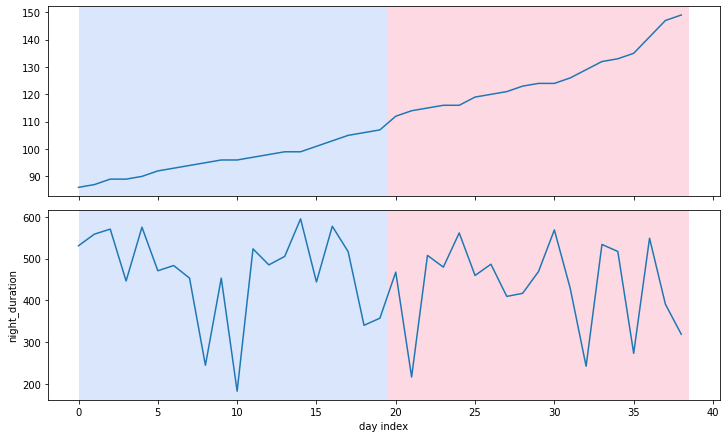

112.0

In [25]:
# example of using the behavioral breakpoint function with plotting. 
behavioral_breakpoint(bedtime[bedtime.uid == 'u05'], 'day', 'night_duration' ,True)

In [26]:
def seating_row(seat_number): 
    """
    input: seat number
    output: section of that seat number, none if the input isn't a valid seat number.
    """
    try: 
        seat_number = int(seat_number)
        for i in range(0, 6): 
            if seat_number in range(i*14 + 1, (i+1)*14 + 1): 
                return i + 1
        return np.NaN
    except: 
        return np.NaN

In [27]:
def usual_row(file): 
    """
    input: a json file of QR codes 
    output: the most sat-in row for that student. 
    """
    try: 
        seats = pd.read_json(file)
        seats['qr_code'] = seats['qr_code'].apply(seating_row)
        return seats['qr_code'].mode().values[0]
    except: 
        return "no qr results"

In [28]:
def apply_seating():
    # this loops through the seating files and adds them to a single dataframe
    seating_files = glob.glob("dataset/EMA/response/QR_code/QR_*.json")
    uid_start = len("dataset/EMA/response/QR_code/QR_")

    uid_list = []
    most_frequent_row = [] 

    for file in seating_files: 
        uid = file[uid_start:uid_start+3]
        uid_list.append(uid)

        most_frequent_row.append(usual_row(file))

    seating_df = pd.DataFrame({'uid': uid_list, 'row': most_frequent_row})
    
    return seating_df

In [29]:
seating_df = apply_seating()

In [30]:
def big_five_nums(response): 
    """
    given a big five response, converts that response into a number corresponding to it's significance level
    1 - disagree strongly to 5 - agree strongly
    """
    if response == 'Disagree Strongly': 
        return 1
    elif response == 'Disagree a little': 
        return 2
    elif response == 'Neither agree nor disagree': 
        return 3
    elif response == 'Agree a little':
        return 4
    elif response == 'Agree strongly': 
        return 5
    else:
        return response

In [31]:
def big_five_c_processing(): 
    """
    returns a dataframe containing conscientiousness scores for each user
    """
    big_five = pd.read_csv('dataset/survey/bigfive.csv')
    big_five = big_five.applymap(big_five_nums)
    # indices match the survey given here:
    # https://uasdata.usc.edu/index.php?r=eNpLtDKyqi62MrFSKkhMT1WyLrYyNAeyS5NyMpP1UhJLEvUSU1Ly80ASQDWJKZkpYDVWSsZK1rVcMEfoEnY    positive_C = big_five.iloc[:, [2, ]]
    positive_C = big_five.iloc[:, [0, 1, 4, 14, 29, 34, 39]]
    negative_C = big_five.iloc[:, [9, 19, 24, 44]]
    reversed_negs = negative_C.applymap(lambda x: 6 - x)
    
    total = pd.concat([positive_C, negative_C], axis = 1)
    total['total conscientiousness'] = total.sum(axis = 1)
    return total

In [190]:
useful_c = big_five_c_processing()[['uid', 'total conscientiousness']][big_five_c_processing()['type'] == 'pre']

In [365]:
def load_attendance(): 
    """
    the class attendance data is loaded from a jupyter notebook made by omkar.
    """
    class_attendance = pd.read_csv('dataset/education/Class Attendance.csv')
    att_per_student = class_attendance.groupby('uid').mean()
    att_per_student['id'] = att_per_student.index
    
    att_per_student.hist(column = 'Actual Rates')
    plt.title('Histogram of Attendance rates per student')
    plt.xlabel('Attendance Rate')
    plt.ylabel('Number of Students')
    
    return att_per_student

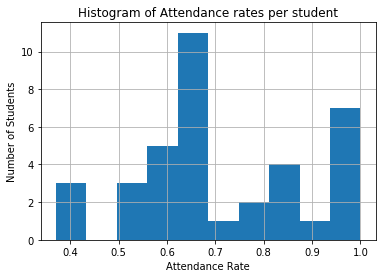

In [366]:
class_attendance = load_attendance()

In [347]:
class_by_dow = class_attendance.groupby('Weekday').sum()

In [545]:
def create_feature_dataframe(): 
    # this dataframe will contain all the features to learn on
    behavioral_df = pd.DataFrame()

    # this list contains all tuples of (dataframe, column) that I want to add to the features dataframe. 
    to_slope = [(bedtime, 'night_duration'), 
                (study_quietness, 'noise while studying'), 
                (study_stillness, 'activity while studying'),
                (study_events, 'study duration'), 
                (darkness, 'darkness duration'),
                (conversations_day, 'day convo duration'), 
                (conversations_evening, 'evening convo duration'),
                (conversations_night, 'night convo duration'),
                (conversation, 'total convo duration'), 
                (activity, ' activity inference'),
                (day_activity, 'day activity inference'), 
                (evening_activity, 'evening activity inference'),
                (night_activity, 'night activity inference'), 
                (indoor_mob, 'average indoor mobility'), 
                (day_im, 'day indoor mobility'), 
                (evening_im, 'evening indoor mobility'), 
                (night_im, 'night indoor mobility'), 
                (partying, 'party duration')
                ]

    # will save runtime by only looking at uids in grades since those are the only ones of interest. 
    grades = pd.read_csv('tables/grades/grades.csv')

    # loop through all uids
    for uid in grades['uid'].unique(): 
        # loop through each (dataframe, column) tuple
        for tup in to_slope: 
            # the uid must be in the dataframe to process it
            if uid in tup[0].uid.unique(): 
                # add slopes, means and breakpoints to the behavioral_df using the append_slopes function 
                df = tup[0]
                column = tup[1]
                try: 
                    behavioral_df = append_slopes_df(df, uid, 'day', column, behavioral_df)
                except: 
                    behavioral_df = append_slopes_df(df.dropna(), uid, 'day', column, behavioral_df)

    # this dataframe 
    behavioral_df = behavioral_df.groupby('uid').sum()
    
    # add data from gps paper, including location variance, speed mean, homestay, and others. 
    gps_transforms = pd.read_csv("GPS_paper/features_10week_all.csv")

    # add gps transforms to the behavioral dataframe
    behavioral_df = behavioral_df.merge(gps_transforms, left_on = 'uid', right_on = 'id', how = 'inner')

    # merge with Ema data
    behavioral_df = behavioral_df.merge(emas, left_on = 'id', right_on = 'uid', how = 'inner')

    # add seating data to the behavioral dataframe
    behavioral_df = behavioral_df.merge(seating_df, left_on = 'id', right_on = 'uid', how = 'inner')
    
    # add conscientiousness data
    behavioral_df = behavioral_df.merge(useful_c, left_on = 'id', right_on = 'uid', how = 'left')
    behavioral_df['total conscientiousness'] = behavioral_df['total conscientiousness'].fillna(
                                                behavioral_df['total conscientiousness'].mean())
    
    behavioral_df = behavioral_df.merge(class_attendance[['id', 'Actual Rates']], on = 'id', how = 'left')
    behavioral_df['Actual Rates'] = behavioral_df['Actual Rates'].fillna(0)
    behavioral_df = behavioral_df.rename(columns = {'Actual Rates': 'Class Attendance'})
    
    # drop id columns so all the dataframe is left with is features (they are ordered, so still correspond with the ordered
    # GPA uids)
    behavioral_df = behavioral_df.drop(columns = ['uid_x', 'id', 'uid_y'])
    
    # this function just adds some extra features. 
    feat_df = extract_7_features_df(behavioral_df)
    
    print(behavioral_df.shape)
    print(feat_df.shape)
    
    behavioral_df = pd.concat([behavioral_df, feat_df[['positive affect', 'stress', 'positive affect post slope']]], axis=1)

    return behavioral_df

In [546]:
behavioral_df = create_feature_dataframe()
behavioral_df.shape

(30, 157)
(30, 7)


(30, 160)

In [547]:
def extract_7_features_df(behavioral_df): 
    """
    creates a dataframe of the 7 features selected by the LASSO regression from the smartgpa paper. these features a
    are conversation duration during night breakpoint, positive affect, conversation duration during evening slope, 
    study duration, positive affect post-slope, stress term-slope, and conscientiousness.
    """
    
    PAM = combine_emas('PAM')
    PAM = PAM[PAM['uid'].isin(grades.uid)]
    
    PAM_mean = PAM.groupby('uid')['picture_idx'].mean()
    
    PAM_slopes = ema_slope(PAM, 'picture_idx')
    
    imp_study_events = study_events[study_events['uid'].isin(grades.uid)]
    study_duration = imp_study_events.groupby('uid')['study duration'].sum()
    
    conscientiousness = useful_c[useful_c['uid'].isin(grades.uid)]
    
    stress = combine_emas('Stress')
    stress = stress[stress.uid.isin(grades.uid)]
    stress_mean = stress.groupby('uid')['level'].mean()
    
    
    small_features_df = pd.DataFrame({'positive affect': PAM_mean.values, 
                                      'night convo duration breakpoint': behavioral_df['night convo duration breakpoint'], 
                                      'evening convo duration term slope': behavioral_df['evening convo duration slope'], 
                                      'study duration': study_duration.values, 
                                      'conscientiousness': behavioral_df['total conscientiousness'], 
                                      'positive affect post slope': PAM_slopes['picture_idx slope'].values,
                                      'stress': stress_mean.values
                                     })
    
    return small_features_df

In [548]:
behavioral_df

,night_duration slope,night_duration mean,night_duration breakpoint,night_duration pre slope,night_duration pre mean,night_duration post slope,night_duration post mean,noise while studying slope,noise while studying mean,noise while studying breakpoint,...,sleep_quality,sleep_rested,people_interacted_with,stress_level,row,total conscientiousness,Class Attendance,positive affect,stress,positive affect post slope
0,-0.164093,421.995238,119.0,4.020310,431.862500,-1.448899,400.164286,-0.012393,0.963071,122.0,...,3.350000,1.850000,3.500000,3.125000,4,32.000000,0.607843,9.971429,2.250000,0.049306
1,-2.059699,428.346296,115.0,-1.166852,468.026667,-1.709380,393.633333,-0.004352,1.114056,131.0,...,3.052632,1.526316,2.800000,3.066667,3,32.000000,0.812500,9.000000,2.066667,0.038360
2,-1.617033,417.591176,104.0,7.012367,471.046667,0.099656,393.591429,0.006630,1.269486,117.0,...,3.000000,1.000000,3.074074,2.232558,2,32.000000,1.000000,8.651376,1.860465,0.096081
3,-1.324367,451.678205,112.0,-4.400206,465.770000,-1.679831,435.131481,0.000120,1.452299,35.0,...,0.000000,0.000000,4.333333,3.875000,4,30.000000,0.622807,9.333333,3.375000,0.700450
4,3.220315,452.329167,112.0,-1.304891,413.399306,-1.210151,532.116667,-0.082633,0.578431,35.0,...,3.066667,1.066667,3.250000,3.773585,1,28.000000,0.000000,9.993197,3.245283,0.057496
5,-0.591977,350.504645,108.0,-4.377251,366.001333,1.041262,341.203810,0.007990,1.200926,114.0,...,3.181818,1.181818,2.767442,2.333333,6,34.000000,0.545455,8.863636,1.800000,-0.028992
6,0.252891,502.914286,123.0,-1.101175,488.478333,-1.454870,512.903333,0.006853,1.057366,88.0,...,0.000000,0.000000,3.000000,3.666667,6,30.000000,1.000000,10.000000,3.000000,1.171226
7,-1.081539,427.941481,116.0,1.226258,447.687222,-1.082490,392.161538,0.002002,0.898692,123.0,...,2.820513,1.230769,3.133333,3.320755,1,31.000000,0.650000,9.706070,2.396226,0.039337
8,-1.148476,467.779667,133.0,0.167124,485.322381,-3.901980,422.122619,0.004033,0.941023,146.0,...,3.400000,1.150000,2.055556,2.766667,1,31.000000,0.000000,8.965174,2.233333,0.020665
9,-0.519706,406.429861,106.0,1.850716,420.232639,1.574997,386.098485,0.005175,1.432985,116.0,...,3.440000,1.440000,3.230769,2.054054,1,31.000000,0.782609,8.176768,2.162162,-0.018110


# Creating the Model

In [549]:
def features_from_df(behavioral_df): 
    # create numpy arrays for learning
    features = behavioral_df.values
    target = grades['spring_gpa'].values

    # check how many features are used (the GPA paper had 193)
    print('features shape: {}'.format(features.shape))
    print('target shape: {}'.format(target.shape))
    
    return features, target

In [550]:
def extract_r_p(behavioral_df): 
    # create a dataframe for containing correlation and p value for each variable
    stats_df = pd.DataFrame()

    # loop through all columns 
    for column in behavioral_df.columns: 
        # calculate correlation and p-value
        try: 
            stats = scipy.stats.pearsonr(behavioral_df[column], grades['spring_gpa'])
        except: 
            print(column)
            continue

        # add the calculated stats to the dataframe.
        new = pd.DataFrame({'stat': [column], 'correlation': [stats[0]], 'p-value': [stats[1]]})
        stats_df = stats_df.append(new, ignore_index = True)

    # making a df of significant values to reduce noise for models 
    sig_stats = stats_df[stats_df['p-value'] < .01]
    sig_df = behavioral_df[sig_stats['stat'].values]
    sig_features = sig_df.values
    return sig_features, sig_stats

In [551]:
features, target = features_from_df(behavioral_df)

features shape: (30, 160)
target shape: (30,)


In [552]:
sig_features, sig_stats = extract_r_p(behavioral_df)

In [553]:
sig_stats

,stat,correlation,p-value
15,activity while studying mean,-0.570090,0.001006
20,activity while studying post mean,-0.595778,0.000513
63,activity inference slope,-0.602225,0.000430
64,activity inference mean,-0.649109,0.000104
67,activity inference pre mean,-0.463997,0.009801
68,activity inference post slope,-0.511609,0.003856
69,activity inference post mean,-0.698006,0.000018
70,day activity inference slope,-0.522365,0.003065
71,day activity inference mean,-0.607890,0.000366
74,day activity inference pre mean,-0.476522,0.007764


In [554]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

In [555]:
def basic_prediction(model, features, target): 
    """
    given input model, features, and target, prints scores of the model on the features
    """
    # split into training and testing data
    X_train, X_test, Y_train, Y_test = train_test_split(features, target, random_state = 2)
    
    # fit the model
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    # print scores
    print('test score: %2f' % model.score(X_test, Y_test))
    print('training score: %2f' % model.score(X_train, Y_train))

In [471]:
def naive_predictions(): 
    scaler = StandardScaler()

    # scale the data to mean 0 and variance 1
    scaled_features = scaler.fit_transform(features)

    # loop through some models and see how they score without much parameter tuning. 
    linear_models = [Lasso(), Lasso(alpha = .01), Ridge(), Ridge(alpha = .01)]
    models = ['Lasso, alpha = 1', 'Lasso, alpha = .01', 'Ridge, alpha = 1', 'Ridge, alpha = .01']

    for index in range(len(linear_models)):
        print(models[index])
        basic_prediction(linear_models[index], scaled_features, target)

These results lead me to believe I'm overfitting the data, I'll try some parameter tuning in a bit. 

In [472]:
# calculating mean absolute error of the model
def loo_r2(predictor, features, target):
    """
    inputs: predictor - machine learning model to fit on the data
            scaled_features - features to fit the model with
            target - goal predictions 
    uses leave one out cross validation to output the mean absolute error of the model. 
    also returns mean absolute error of the model
    """
    
    # split the data leaving one user out in each split
    leave_one = LeaveOneOut()
    loo = leave_one.split(X = scaled_features, y = target)

    # loop through all the splits
    results = []
    for train_index, test_index in loo:
        X_train = features[train_index]
        Y_train = target[train_index]
        X_test = features[test_index]
        Y_test = target[test_index]
        
        # add the predicted and actual value to the results list
        try: 
            predictor.fit(X_train, Y_train)
        except:
            print(X_train)
        results.append([float(predictor.predict(X_test)), float(Y_test)])
        
        
    # R^2 = (1-u/v) where u is residual sum of squares (y_true - y_pred) and v is the total sum of squares 
    # (y_true - y_true.mean()) ** 2 taken from 
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
    u = 0
    v = 0
    total = 0
    
    for res in results: 
        u += (res[1] - res[0])**2
        v += (res[1] - target.mean())**2
        total += abs(res[1]-res[0])
        
    total = total/len(results)
    
    return 1-u/v, total

In [587]:
def grades_gridsearch(model, features, target, param_grid): 
    """
    inputs: model - machine learning model to fit on the data (either ridge or lasso)
            features - features to fit the model with
            target - goal predictions 
    outputs: the optimal alpha value for the model
    """
    # use a gridsearch with cross validation to find the best parameters

    # find the best parameters on the X_train and Y_train set, then use them on the test set
    #X_train, X_test, Y_train, Y_test = train_test_split(features, target, random_state = 1)

    # implementing the grid search
    grid = GridSearchCV(model, param_grid, cv = 5)

    grid.fit(features, target)

    # print scoring and parameters
    print("Best parameters, scaling: {}".format(grid.best_params_))
    print("Best cross-validation score, scaling: {:.2f}".format(grid.best_score_))
    
    return grid.best_params_

In [474]:
def pipeline(): 
    # adding a polynomial pipeline and testing it. Is not helpful. 
    pipe = Pipeline([('polynomial', PolynomialFeatures()), 
                     ('scaler', StandardScaler()), ('lasso', Lasso(alpha = best_alpha))])

    X_train, X_test, Y_train, Y_test = train_test_split(scaled_features, target, random_state = 1)

    pipe.fit(X_train, Y_train)

    print('score with polynomial features added: {:.4f}'.format(pipe.score(X_test, Y_test)))

The model clearly still needs more work. While it occasionally performs well, I need to work more on the tuning of the hyperparameters, since lasso especially is very sensitive to those, and add some more data. If the model continues to overfit, I will need to impose more regularization or lean more on only using significant features when fitting the model. 

In [556]:
naive_predictions()
scaled_features = StandardScaler().fit_transform(features)
scaled_sig_features = StandardScaler().fit_transform(sig_features)

Lasso, alpha = 1
test score: -0.084240
training score: 0.000000
Lasso, alpha = .01
test score: 0.187517
training score: 0.997712
Ridge, alpha = 1
test score: -0.010064
training score: 0.999920
Ridge, alpha = .01
test score: -0.014136
training score: 1.000000


In [575]:
linear_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
best_lasso_alpha = grades_gridsearch(Lasso(max_iter = 100000), scaled_features, target, linear_param_grid)

Best parameters, scaling: {'alpha': 0.1}
Best cross-validation score, scaling: -0.33


In [576]:
best_ridge_alpha = grades_gridsearch(Ridge(max_iter = 100000), scaled_features, target, linear_param_grid)

Best parameters, scaling: {'alpha': 100}
Best cross-validation score, scaling: -0.19


In [577]:
best_sig_lasso_alpha = grades_gridsearch(Lasso(max_iter = 100000), scaled_sig_features, target, linear_param_grid)

Best parameters, scaling: {'alpha': 1}
Best cross-validation score, scaling: -0.45


In [578]:
best_sig_ridge_alpha = grades_gridsearch(Ridge(max_iter = 100000), scaled_sig_features, target, linear_param_grid)

Best parameters, scaling: {'alpha': 100}
Best cross-validation score, scaling: -0.23


In [561]:
print('Lasso r^2 (leave one out cv): {:.3f}'.format(loo_r2(Lasso(max_iter = 1000000, 
                                                                 alpha = best_lasso_alpha), scaled_features, target)[0]))
print('Ridge r^2 (leave one out cv): {:.3f}'.format(loo_r2(Ridge(max_iter = 1000000, 
                                                              alpha = best_ridge_alpha), scaled_features, target)[0]))

print('Lasso mae (leave one out cv): {:.3f}'.format(loo_r2(Lasso(max_iter = 1000000, 
                                                                 alpha = best_lasso_alpha), scaled_features, target)[1]))
print('Ridge mae (leave one out cv): {:.3f}'.format(loo_r2(Ridge(max_iter = 1000000, 
                                                              alpha = best_ridge_alpha), scaled_features, target)[1]))

Lasso r^2 (leave one out cv): 0.196
Ridge r^2 (leave one out cv): 0.217
Lasso mae (leave one out cv): 0.504
Ridge mae (leave one out cv): 0.500


In [562]:
print('Sig Lasso r^2 (leave one out cv): {:.3f}'.format(loo_r2(Lasso(max_iter = 1000000, 
                                                            alpha = best_sig_lasso_alpha), sig_features, target)[0]))
print('Sig Ridge r^2 (leave one out cv): {:.3f}'.format(loo_r2(Ridge(max_iter = 1000000, 
                                                             alpha = best_sig_ridge_alpha), sig_features, target)[0]))

print('Sig Lasso mae (leave one out cv): {:.3f}'.format(loo_r2(Lasso(max_iter = 1000000, 
                                                            alpha = best_sig_lasso_alpha), sig_features, target)[1]))
print('Sig Ridge mae (leave one out cv): {:.3f}'.format(loo_r2(Ridge(max_iter = 1000000, 
                                                             alpha = best_sig_ridge_alpha), sig_features, target)[1]))

Sig Lasso r^2 (leave one out cv): -0.070
Sig Ridge r^2 (leave one out cv): -0.041
Sig Lasso mae (leave one out cv): 0.564
Sig Ridge mae (leave one out cv): 0.561


# Plotting with Unsupervised Learning

In [53]:
from sklearn.manifold import TSNE

def plot_tsne(features):
    """
    given input features plots tsne with 5 perplexities
    """
    scaled_grades_features = StandardScaler().fit_transform(features)
    
    for perp in [5, 10, 30, 100]: 
        transformed_features = TSNE(n_components=2, perplexity = perp).fit_transform(scaled_grades_features)

        #plt.scatter(x = transformed_features[:, 0], y = transformed_features[:, 1])

        to_plot = pd.DataFrame({'comp_1': transformed_features[:, 0], 'comp_2': transformed_features[:, 1],
                                'grades': target, 'deans_list': grades['deans_list']})

        sns.relplot(x = 'comp_1', y = 'comp_2', size = 'grades', data = to_plot, sizes = (20, 200), hue = 'deans_list')
        plt.title('perplexity {}'.format(perp))
        plt.figure()


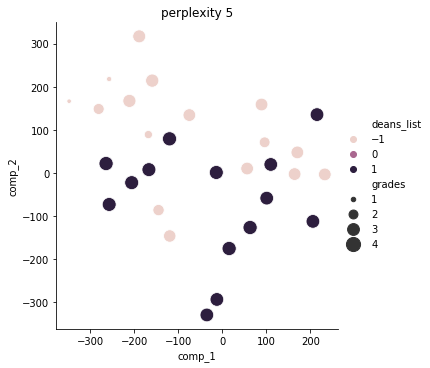

<Figure size 432x288 with 0 Axes>

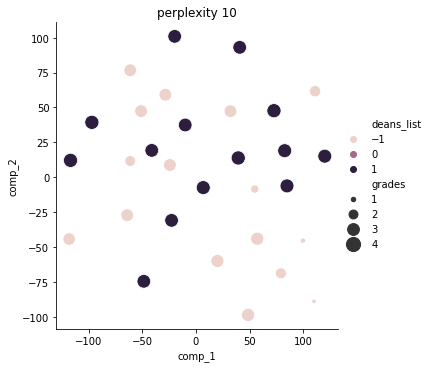

<Figure size 432x288 with 0 Axes>

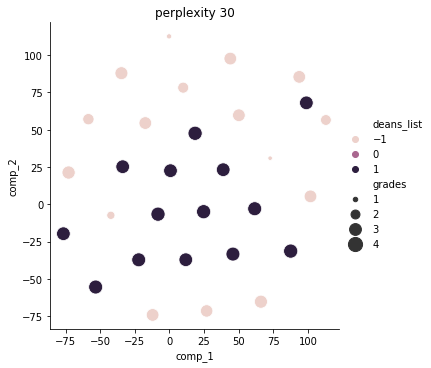

<Figure size 432x288 with 0 Axes>

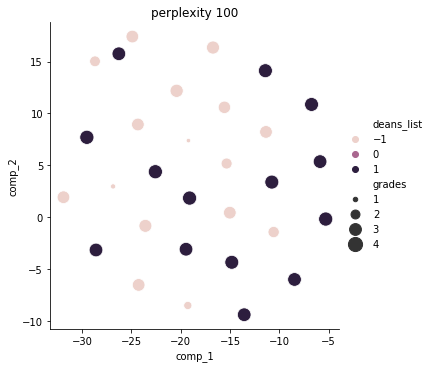

<Figure size 432x288 with 0 Axes>

In [54]:
plot_tsne(features)

There isn't an evident pattern in any of the tsne graphs, so i'll try a PCA

Again, there is appears to be no pattern in the data

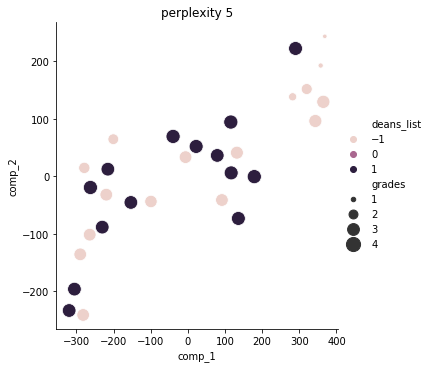

<Figure size 432x288 with 0 Axes>

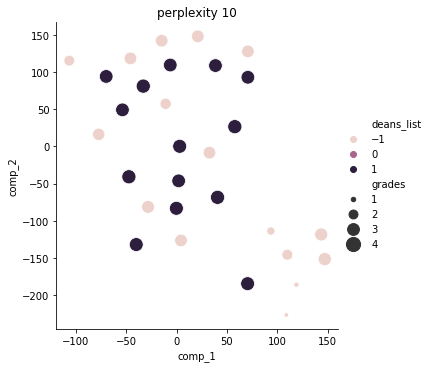

<Figure size 432x288 with 0 Axes>

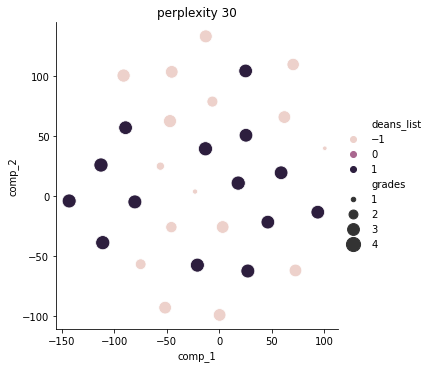

<Figure size 432x288 with 0 Axes>

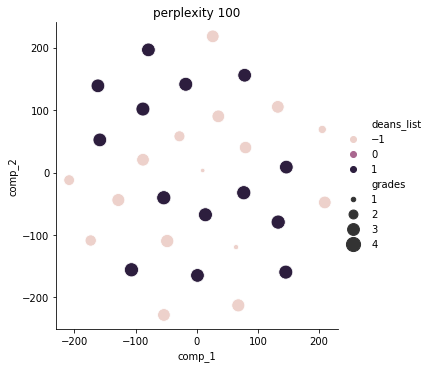

<Figure size 432x288 with 0 Axes>

In [55]:
plot_tsne(sig_features)

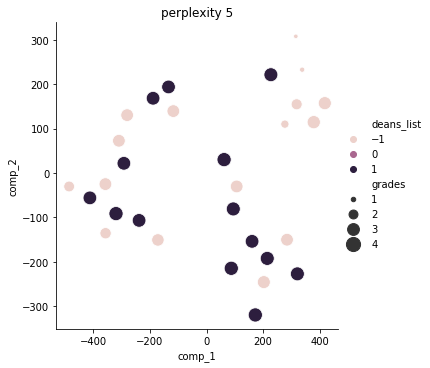

<Figure size 432x288 with 0 Axes>

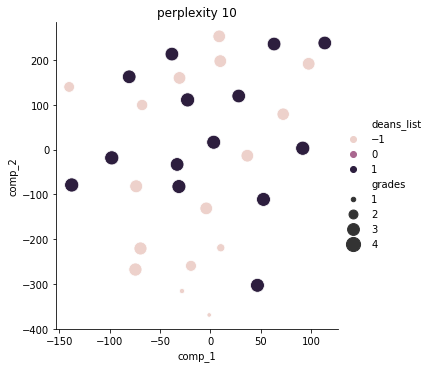

<Figure size 432x288 with 0 Axes>

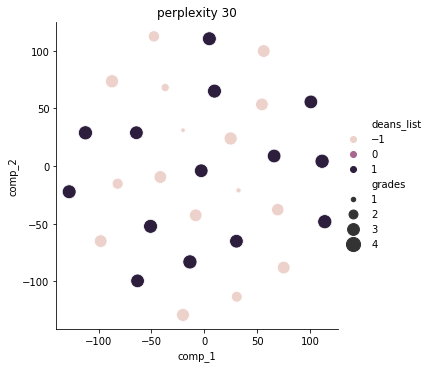

<Figure size 432x288 with 0 Axes>

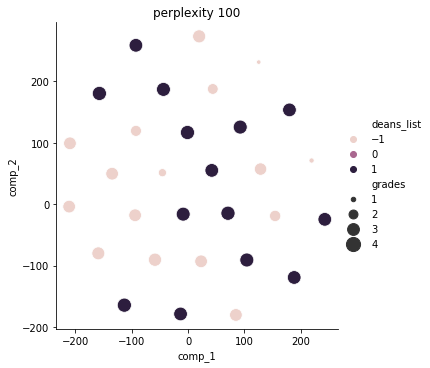

<Figure size 432x288 with 0 Axes>

In [56]:
plot_tsne(scaled_sig_features)

There is a noticeable pattern in the signifcant features tsne with perplexity 30, but not a noticeable pattern in the scaled significant features or the total features set. As a result, in further analysis, I will use the the unscaled signficant features to in another grid search and test. 

In [57]:
from sklearn.decomposition import PCA
def plot_pca(features):
    """
    given input features plots a principal component analysis (first two components)
    """
    # keep the first two principal components of the data
    pca = PCA(n_components=2)
    pg_transformed = pca.fit_transform(features)
    pg_df = pd.DataFrame(data = pg_transformed, columns = ['PC_1', 'PC_2'])
    pg_df['deans_list'] = grades['deans_list']
    #print("component 1 weights: ", pca.components_[0])
    #print("component 2 weights: ", pca.components_[1])
    print("variance explained: ", pca.explained_variance_ratio_)
    sns.relplot(x = 'PC_1', y = 'PC_2', hue = 'deans_list', kind = 'scatter', data = pg_df)

variance explained:  [0.71849667 0.16875808]


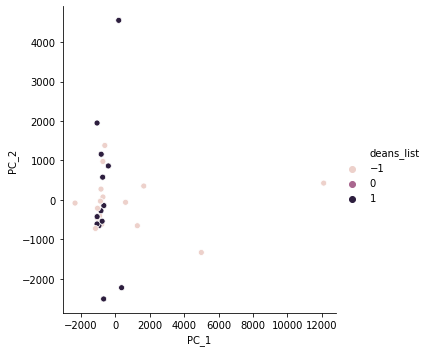

In [58]:
plot_pca(features)

variance explained:  [0.84048663 0.09916688]


Text(0.5, 1, 'Principal Component Analysis on significant features')

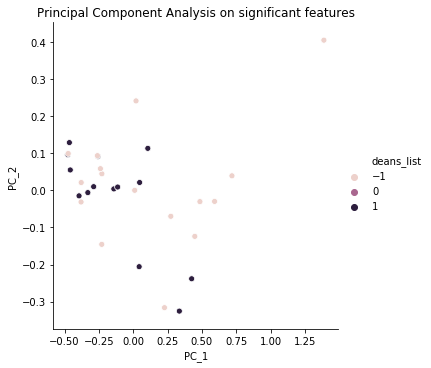

In [59]:
plot_pca(sig_features)
plt.title('Principal Component Analysis on significant features')

In [60]:
sig_lasso_alpha = grades_gridsearch(Lasso(max_iter = 100000), sig_features, target)

Best parameters, scaling: {'alpha': 0.1}
Best cross-validation score, scaling: -0.41


# Attempting to make the model with only the 7 features used in the final GPA paper

In [113]:
def combine_emas(ema_name): 
    """
    input: ema_name -- name of the ema we're looking at
    output: dataframe containing the data from the desired ema compiled for all uids
    """
    # list of all the desired ema's 
    all_emas = glob.glob('dataset/EMA/response/' + ema_name + '/' + ema_name +'_*.json')
    # index to start the uid
    uid_start = len('dataset/EMA/response/' + ema_name + '/' + ema_name +'_')
    # this is where we'll compile the data
    total_ema_data = pd.DataFrame()
    # loops through all the ema data
    for ema in all_emas: 
        # the uid is the three characters starting at uid_start index
        uid = ema[uid_start:uid_start + 3]
        # read the data
        ema_data = pd.read_json(ema)
        # keep track of uids
        ema_data['uid'] = uid
        # compile the data
        total_ema_data = total_ema_data.append(ema_data)
    
    total_ema_data['day of week'] = total_ema_data['resp_time'].dt.dayofweek
    total_ema_data['day'] = total_ema_data['resp_time'].dt.dayofyear
    return total_ema_data    

In [258]:
def ema_post_slope(ema_df, col):
    """
    input: dataframe with ema data, col which is the desired column for the slope
    output: slope for the desired column after the breakpoint for the term for each user id 
    """
    agg_df = pd.DataFrame()
    
    for uid in ema_df['uid'].unique(): 
        
        # take the data specific to each user and average them by day. 
        uid_ema = ema_df[ema_df.uid == uid]
        uid_ema = uid_ema.groupby('day').mean()
        
        # the index is going to be day since we grouped by day
        uid_ema['day'] = uid_ema.index
        
        # this function finds the behavioral breakpoint of the ema data. See the function for further explanation
        breakpoint = behavioral_breakpoint(uid_ema, 'day', col)
        
        # only take data after the breakpoint
        post_breakpoint_data = uid_ema[uid_ema['day'] > breakpoint]
        
        
        slope = linear_coef(post_breakpoint_data['day'], post_breakpoint_data[col])
        
        agg_df = agg_df.append(pd.DataFrame({'uid': uid, col + ' slope': slope}))
    
    return agg_df

In [524]:
feat_df = extract_7_features_df()
# make a numpy array for the features
small_features = feat_df.values
feat_df

,night convo duration breakpoint,evening convo duration term slope
0,115.0,-0.240518
1,115.0,-0.240518
2,115.0,-3.545691
3,115.0,-3.545691
4,106.0,0.831401
5,118.0,-2.313028
6,118.0,-2.313028
7,118.0,-2.313028
8,118.0,0.721993
9,118.0,0.721993


In [303]:
# this is our array of gpas for the corresponding ordered uids
target

array([1.77777778, 4.        , 3.5       , 3.77777778, 4.        ,
       3.33333333, 3.77777778, 3.77777778, 2.58333333, 3.88888889,
       3.33333333, 4.        , 3.33333333, 3.33333333, 3.77777778,
       3.91666667, 3.22222222, 3.33333333, 3.33333333, 3.91666667,
       3.88888889, 2.77777778, 3.77777778, 4.        , 1.11111111,
       3.77777778, 1.        , 3.44444444, 2.66666667, 3.55555556])

In [458]:
scaled_small_features = MinMaxScaler().fit_transform(small_features)
#scaled_small_features

In [448]:
best_small_alpha = grades_gridsearch(Ridge(max_iter = 100000), scaled_small_features, target)

Best parameters, scaling: {'alpha': 10}
Best cross-validation score, scaling: -0.43


In [457]:
print('Scaled Lasso r^2 (leave one out cv): {:.3f}'.format(loo_r2(Lasso(max_iter = 1000000, 
                                                             alpha = best_small_alpha), scaled_small_features, target)[0]))

print('Scaled Lasso mae (leave one out cv): {:.3f}'.format(loo_r2(Lasso(max_iter = 1000000, 
                                                            alpha = best_small_alpha), scaled_small_features, target)[1]))

Scaled Lasso r^2 (leave one out cv): -0.070
Scaled Lasso mae (leave one out cv): 0.564


# Applying a gradient boosted regressor

In [614]:
from sklearn.ensemble import GradientBoostingRegressor

In [616]:
def gradient_boosting_gridsearch(features, target, scoring): 
    """
    inputs: features, target and scoring preferences
    outputs: a dictionary of the best parameters for the gradient boosting regressor. 
    """
    param_grid = {'learning_rate': [.01, .1, 1, 10, 100],
                  'max_depth': [1, 3, 5, 7, 9]}
    
    return grades_gridsearch(GradientBoostingRegressor(loss = scoring), features, target, param_grid)

In [617]:
# i choose to use lad because it gives me the fewest overflow messages. 
best_params = gradient_boosting_gridsearch(features, target, 'lad')

C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\metrics\_regr

Best parameters, scaling: {'learning_rate': 0.01, 'max_depth': 7}
Best cross-validation score, scaling: -0.15


C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:591: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,
C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
C:\Users\Lowell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:788: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


In [620]:
new_grad = GradientBoostingRegressor(loss = 'lad', learning_rate = best_params['learning_rate'], 
                                    max_depth = best_params['max_depth'])

error = loo_r2(new_grad, scaled_features, target)

print('Gradient Boosting Regressor r^2 (leave one out cv): {:.3f}'.format(error[0]))
print('Gradient Boosting Regressor mae (leave one out cv): {:.3f}'.format(error[1]))

Gradient Boosting Regressor r^2 (leave one out cv): 0.002
Gradient Boosting Regressor mae (leave one out cv): 0.497


The gradient boosting regressor isn't any better than the lasso or ridge regressors right now. 